<a href="https://colab.research.google.com/github/Swayms-stack/AutoMail/blob/main/3D_Object_detection_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3D Object detection classifier




In [ ]:
!pip install trimesh
import os
import glob    # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import trimesh    # loading and using triangular meshes which allow for easy manipulation and analysis, in the style of the Polygon object
import numpy as np
import tensorflow as tf      # numerical computation and large-scale machine learning
from tensorflow import keras         # Keras is a powerful easy-to-use Python library for developing and evaluating deep learning models
from tensorflow.keras import layers    
from matplotlib import pyplot as plt
!pip install tqdm
from tqdm import *         # tqdm progress bar not only shows how much time has elapsed, but also shows the estimated time remaining for the iterable

tf.random.set_seed(1234)
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 660 kB 33.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 3D object detection classifier used is Kaolin framework

!git clone https://github.com/gkadusumilli/kaolin_1.git

Cloning into 'kaolin_1'...
remote: Enumerating objects: 519, done.
remote: Total 519 (delta 0), reused 0 (delta 0), pack-reused 519
Receiving objects: 100% (519/519), 44.60 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
'''Kaolin is an open-source PyTorch library developed by a team of NVIDIA, aimed at accelerating 3D deep learning research.
Kaolin framework converts the 3D models into deep learning datasets with few lines of code. '''

%cd /content/kaolin_1/Documents/kaolin-0.1
!python setup.py build_ext --inplace

/content/kaolin_1/Documents/kaolin-0.1
WARNING - Kaolin is tested with PyTorch >=1.2.0, <1.5.0 Found version 1.12.1+cu113 instead.
WARNING - Kaolin is tested with torchvision >=0.4.0, <0.6.0 Found version 0.13.1+cu113 instead.
Building nv-usd...
sh: 1: ./buildusd.sh: Permission denied
running build_ext
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:813: UserWarning: The detected CUDA version (11.1) has a minor version mismatch with the version that was used to compile PyTorch (11.3). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
building 'kaolin.triangle_hash' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/kaolin
creating build/temp.linux-x86_64-3.7/kaolin/cython
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstac

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")


473415680/473402300 [==============================] - 38s 0us/step


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0001.off"))
mesh.show()

In [ ]:
import torch
from torch.utils.data import DataLoader
!pip install pptk
import kaolin as kal
from kaolin import ClassificationEngine
from kaolin.datasets import ModelNet
from kaolin.models.PointNet import PointNetClassifier
import kaolin.transforms as tfs
from torchvision.transforms import Lambda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.8 MB 1.6 MB/s 
   No module named 'nuscenes'
   None


Traceback (most recent call last):
  File "/content/kaolin_1/Documents/kaolin-0.1/kaolin/datasets/__init__.py", line 11, in <module>
    from .nusc import NuscDetection
  File "/content/kaolin_1/Documents/kaolin-0.1/kaolin/datasets/nusc.py", line 21, in <module>
    from nuscenes.utils.geometry_utils import transform_matrix
ModuleNotFoundError: No module named 'nuscenes'


In [ ]:
# model_path the variable will hold the path to the ModelNet10 dataset
modelnet_path = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")
print(modelnet_path)
# categories variable to specify which classes we want to learn to classify
categories = ['chair', 'sofa', 'bed','night_stand']
# num_points is the number of points we will sample from the mesh when transforming it to a point cloud
num_points=1024
device='cuda'   # disable multiprocessing and memory pinning
workers = 8

#training parameters
batch_size = 12
learning_rate = 1e-3
epochs = 10

/root/.keras/datasets/ModelNet10


In [ ]:
'''This command defines a transform that first converts a mesh representation to a point cloud and then normalizes it to be centered at the origin, 
and has a standard deviation of 1. 
Much like images, 3D data such as point clouds need to be normalized for better classification performance.'''

def to_device(inp):
    inp.to(device)
    return inp

transform = tfs.Compose([
    to_device,
    tfs.TriangleMeshToPointCloud(num_samples=num_points),
    tfs.NormalizePointCloud()
])

num_workers = 0 if device == 'cuda' else workers
pin_memory = device != 'cuda'

In [ ]:
# split='train' argument indicates that the 'train' split is loading.
train_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                   split='train', transform=transform),
                          batch_size=batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
val_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                 split='test',transform=transform),
                        batch_size=batch_size, num_workers=num_workers,
                        pin_memory=pin_memory)

In [ ]:
# Setting up our model, optimizer, and loss criterion
model = PointNetClassifier(num_classes=len(categories)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# Training & Validating the PointNet classifier 
# 3D object detection classifier using Kaolin
for e in range(epochs):
    print(f'{"":-<10}\nEpoch: {e}\n{"":-<10}')

    train_loss = 0.
    train_accuracy = 0.

    model.train()
    for batch_idx, (data, attributes) in enumerate(tqdm(train_loader)):
        category = attributes['category'].to(device)
        pred = model(data)
        loss = criterion(pred, category.view(-1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Compute accuracy
        pred_label = torch.argmax(pred, dim=1)
        train_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Train loss:', train_loss / len(train_loader))
    print('Train accuracy:', train_accuracy / len(train_loader))

    val_loss = 0.
    val_accuracy = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, attributes) in enumerate(tqdm(val_loader)):
            category = attributes['category'].to(device)
            pred = model(data)
            loss = criterion(pred, category.view(-1))
            val_loss += loss.item()

            # Compute accuracy
            pred_label = torch.argmax(pred, dim=1)
            val_accuracy += torch.mean((pred_label == category.view(-1)).float()).item()

    print('Val loss:', val_loss / len(val_loader))
    print('Val accuracy:', val_accuracy / len(val_loader))

----------
Epoch: 0
----------


100%|██████████| 191/191 [04:01<00:00,  1.27s/it]


Train loss: 0.26559403195431097
Train accuracy: 0.9105584773561717


100%|██████████| 33/33 [00:31<00:00,  1.06it/s]


Val loss: 0.6042501456509909
Val accuracy: 0.7929293025623668
----------
Epoch: 1
----------


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


Train loss: 0.15916980095500252
Train accuracy: 0.9489528895672703


100%|██████████| 33/33 [00:29<00:00,  1.12it/s]


Val loss: 0.6056506650691683
Val accuracy: 0.7297979870980437
----------
Epoch: 2
----------


100%|██████████| 191/191 [03:44<00:00,  1.17s/it]


Train loss: 0.15239212144146727
Train accuracy: 0.9524432904433205


100%|██████████| 33/33 [00:30<00:00,  1.09it/s]


Val loss: 0.3540231183763932
Val accuracy: 0.8737373893911188
----------
Epoch: 3
----------


100%|██████████| 191/191 [03:44<00:00,  1.18s/it]


Train loss: 0.15506380742796116
Train accuracy: 0.9568062917724329


100%|██████████| 33/33 [00:29<00:00,  1.11it/s]


Val loss: 0.3157001365806068
Val accuracy: 0.8838383952776591
----------
Epoch: 4
----------


100%|██████████| 191/191 [03:43<00:00,  1.17s/it]


Train loss: 0.11809189780980972
Train accuracy: 0.9637870932124672


100%|██████████| 33/33 [00:30<00:00,  1.09it/s]


Val loss: 0.15429312986353497
Val accuracy: 0.9545454635764613
----------
Epoch: 5
----------


100%|██████████| 191/191 [03:45<00:00,  1.18s/it]


Train loss: 0.10224065740461125
Train accuracy: 0.966404893323389


100%|██████████| 33/33 [00:30<00:00,  1.09it/s]


Val loss: 0.6346425297740621
Val accuracy: 0.7853535388906797
----------
Epoch: 6
----------


100%|██████████| 191/191 [03:44<00:00,  1.18s/it]


Train loss: 0.10846831451270106
Train accuracy: 0.9607329927189812


100%|██████████| 33/33 [00:30<00:00,  1.09it/s]


Val loss: 0.1663612362533582
Val accuracy: 0.9469697041945024
----------
Epoch: 7
----------


100%|██████████| 191/191 [03:47<00:00,  1.19s/it]


Train loss: 0.1121855070497548
Train accuracy: 0.9646596933534632


100%|██████████| 33/33 [00:29<00:00,  1.11it/s]


Val loss: 0.27234368220811256
Val accuracy: 0.9065656661987305
----------
Epoch: 8
----------


100%|██████████| 191/191 [03:47<00:00,  1.19s/it]


Train loss: 0.061362328662424886
Train accuracy: 0.9808027968980879


100%|██████████| 33/33 [00:29<00:00,  1.10it/s]


Val loss: 0.29818216178065277
Val accuracy: 0.8813131397420709
----------
Epoch: 9
----------


100%|██████████| 191/191 [03:47<00:00,  1.19s/it]


Train loss: 0.09307025031903417
Train accuracy: 0.9703315948940696


100%|██████████| 33/33 [00:29<00:00,  1.10it/s]

Val loss: 0.146453045294479
Val accuracy: 0.964646471269203


In [ ]:
# Evaluating the trained 3D object detection model on test data
'''A new data loader that will load the same data as the previous val_loader 
 but with shuffling, and taking a sample batch is created.'''
test_loader = DataLoader(ModelNet(modelnet_path, categories=categories,
                                  split='test',transform=transform),
                        shuffle=True, batch_size=15)

data, attr = next(iter(test_loader))
data = data.to('cuda')
labels = attr['category'].to('cuda')
preds = model(data)
pred_labels = torch.max(preds, axis=1)[1]

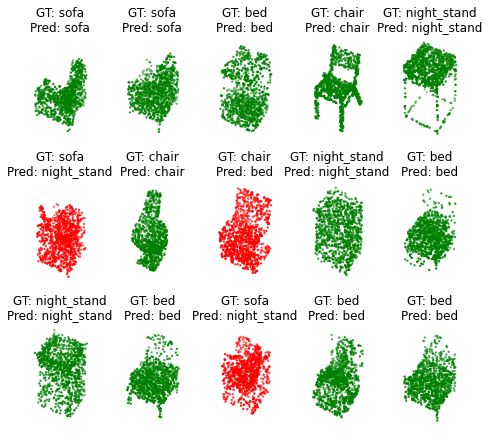

In [ ]:
'''A plot to visualize the point cloud, ground-truth label, and the prediction using a small visualization function.
color-coded the results — green for correct and red for incorrect.'''
color-coded the results — green for correct and red for incorrect.
from mpl_toolkits.mplot3d import Axes3D     # import necessary to have access to 3d projection 
import matplotlib.pyplot as plt
%matplotlib inline


def visualize_batch(pointclouds, pred_labels, labels, categories):
    batch_size = len(pointclouds)
    fig = plt.figure(figsize=(8, batch_size / 2))

    ncols = 5
    nrows = max(1, batch_size // 5)
    for idx, pc in enumerate(pointclouds):
        label = categories[labels[idx].item()]
        pred = categories[pred_labels[idx]]
        colour = 'g' if label == pred else 'r'
        pc = pc.cpu().numpy()
        ax = fig.add_subplot(nrows, ncols, idx + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colour, s=2)
        ax.axis('off')
        ax.set_title('GT: {0}\nPred: {1}'.format(label, pred))

    plt.show()
visualize_batch(data, pred_labels, labels, categories)

# GT- Ground Truth, Pred- Prediction.
